# The HFM library - A fast marching solver with adaptive stencils

## Part : Motion planning
## Chapter : Minimal paths with curvature penalization and obstacles (Interactive)

In this notebook, we illustrate curvature penalized paths, within domains with obstacles, in an interactive fashion.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Demo](#1.-Demo)
    * [1.1 Choice of a vehicle model](#1.1-Choice-of-a-vehicle-model)
    * [1.2 Obstacles](#1.2-Obstacles)
    * [1.3 Seeds and tips](#1.3-Seeds-and-tips)
    * [1.4 Running the eikonal solver](#1.4-Running-the-eikonal-solver)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries.

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Interactive_CurvatureObstacles','FMM'))

In [2]:
from agd import AutomaticDifferentiation as ad
from agd import Eikonal
from agd.Plotting import imshow_ij,arr2fig,fig2arr,pick_lines,pick_points,input_default
from agd.Plotting import savefig; savefig.dirName = "Figures/CurvatureObstacles"

In [3]:
import numpy as np; xp=np
from matplotlib import pyplot as plt

In [4]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global pick_lines
    pick_lines, = rreload([pick_lines],rootdir="../../AdaptiveGridDiscretizations")

### 0.1 Additional configuration

Uncomment the following line for interactive user input. Default values are always provided. 

**Interactive input is UNAVAILABLE on Google Colab,** since it requires the `tk` matplotlib frontend, which is not supported on this platform. 

In [5]:
interactive=False

Wether to use GPU acceleration.

In [6]:
#xp,Eikonal,plt,arr2fig,imshow_ij = [ad.cupy_friendly(e) for e in (xp,Eikonal,plt,arr2fig,imshow_ij)]

In [7]:
dimx = 200 if xp is np else 400 # Domain dimension

## 1. Demo

### 1.1 Choice of a vehicle model

Four classical non-holonomic vehicle models models are presented, corresponding to increasingly steep penaliaztion functions $\mathcal C(\kappa)$ of the rescaled curvature $\kappa = \xi |\theta'|$, which $\xi$ is a parameter which can be regarded as a typical radius of curvature of the trajectory. See the notebook on [curvature penalization](Curvature.ipynb) for more discussion. 

Model|Reeds-Shepp|Euler elastica|Dubins
-:|-|-|:-
$\mathcal C(\kappa)$|$\sqrt{1+\kappa^2}$|$1+\kappa^2$|$1+\chi_{|\kappa|\leq 1}$

The characteristic function notation $\chi_P$ stands for $0$ where $P$ holds, and $+\infty$ otherwise. 

**Interaction.** Choose a vehicle model.

In [8]:
models = {
    0:('ReedsShepp2',0.7),
    1:('ReedsSheppForward2',0.7),
    2:('Elastica2',0.3),
    3:('Dubins2',0.3)
}

#Choose model among the previous list.
imodel = 2 
if interactive: imodel = int(input_default("Choose a vehicle model",str(imodel)))
    
model,xi = models[imodel]
if interactive: xi = float(input_default("Choose a typical curvature radius",str(xi)))

In [9]:
hfmIn = Eikonal.dictIn({
    'model':model,
    'xi':xi,
    'cost':1,
})
hfmIn.SetRect([[0,2],[0,1]],dimx=dimx) # Domain is [0,2]x[0,1]
hfmIn.nTheta = 64

In [10]:
emptydomain = xp.zeros(hfmIn.shape[:2]).astype(np.int8)

### 1.2 Obstacles

The Eikonal solvers provided in the `agd` and `hfm` libraries expect the obstacles to be defined as boolean maps. Within this demo, these obstacles are rasterised from user provided scribbles. 

Note that the minimal paths are computed within the position-orientation domain $\Omega\times S^1$, where $\Omega\subset R^2$ is the physical domain. The obstacles considered in this notebook are of physical type, i.e. of the form $A \times S^1$, whereas obstacles of angular type are considered in [convex region segmentation](Interactive_ConvexRegionSegmentation.ipynb), i.e. of the form $\Omega \times \{\theta_*\}$. Other applications, such as the sofa moving problem, may involve fully generic obstacles defined as an abitrary subset of $\Omega \times S^1$. 

**Interaction.** Define some physical obstacles, as a collection of broken lines (type enter after each), which are then rasterized.

In [11]:
lines = [[[29, 79, 114], [47, 69, 45]], [[88, 119, 171, 162], [32, 17, 20, 73]]]
lines = [np.array(line)*dimx/200 for line in lines]
if interactive:
    %matplotlib tk 
    imshow_ij(emptydomain,cmap='Greys')
    newlines = pick_lines()
    if len(newlines): lines=newlines
#[np.round(line).astype(int).tolist() for line in lines]

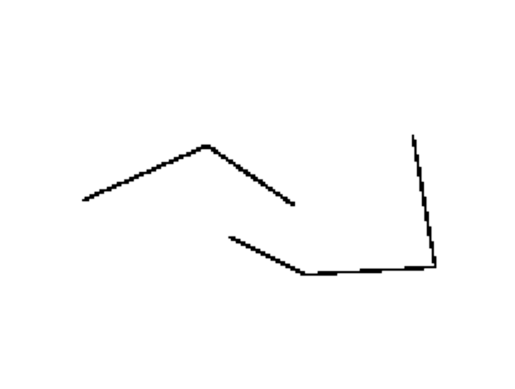

In [12]:
%matplotlib inline
fig = arr2fig(emptydomain,cmap='Greys');
for line in lines: plt.plot(*line,color='black',aa=False,linewidth=1)
obstacles = fig2arr(fig,emptydomain.shape)
obstacles = xp.array(obstacles[:,:,0]<1)
#fig.savefig(savefig.dirName+"/Obstacles.png",dpi = obstacles.shape[0]/fig.get_size_inches()[0])
plt.close()

fig = plt.figure(); plt.axis('equal'); plt.axis('off')
imshow_ij(obstacles,cmap='Greys');

### 1.3 Seeds and tips

We compute globally optimal shortest paths from a set of *seed* points, to a set of *tips*.
These points below to the position-orientation space $\Omega\times S^1$, hence they feature both an physical coordinate $x$ and an angular coordinate $\theta$.

**Interaction.** Define one or several seed points, presented as arrows (point and direction).

In [13]:
seeds = np.array([[[53, 64], [23, 47]], [[174, 182], [84, 52]]])*dimx/200
if interactive:
    %matplotlib tk
    imshow_ij(obstacles,cmap='Greys')
    newseeds = pick_lines(broken=False,arrow=True)
    if len(newseeds): seeds=newseeds
seeds=xp.array(seeds)
#np.round(seeds).astype(int).tolist()

**Interaction.** Define one or several tip points, presented as arrows (point and direction).

In [14]:
tips = np.array([[[35, 17], [83, 62]], [[174, 187], [12, 28]], [[119, 127], [71, 54]], 
              [[73, 97], [14, 14]], [[41, 29], [17, 20]], [[71, 89], [87, 87]]])*dimx/200
if interactive:
    %matplotlib tk
    imshow_ij(obstacles,cmap='Greys')
    for seed in seeds: plt.arrow(*seed[:,0],*(seed[:,1]-seed[:,0]),color='blue',head_width=3)
    newtips = pick_lines(broken=False,arrow=True)
    if len(newtips): tips=newtips
tips = xp.array(tips)
#np.round(tips).astype(int).tolist()

Obstacles shown black, seeds shown blue, tips shown red. 

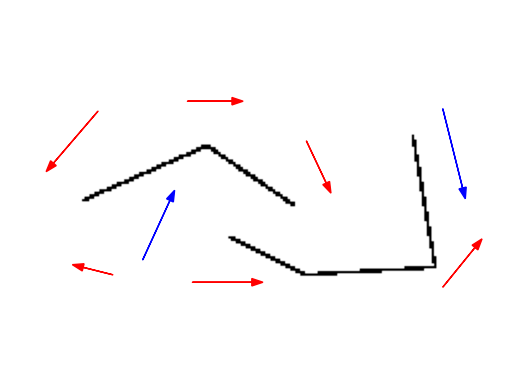

In [15]:
%matplotlib inline
fig = plt.figure(); plt.axis('equal'); plt.axis('off')
imshow_ij(obstacles,cmap='Greys')
for seed in seeds: plt.arrow(*seed[:,0],*(seed[:,1]-seed[:,0]),color='blue',head_width=3)
for tip in tips:   plt.arrow(*tip[:,0], *(tip[:,1]-tip[:,0]),  color='red', head_width=3)
#savefig(fig,"Input.png")

In [16]:
def indexpair2lifted(hfmIn,index0,index1):
    """
    Input : a pair of image multi-indices. 
    Output : a lifted point.
    (Also works for several, convention : geometry last)
    """
    p0,p1 = [hfmIn.PointFromIndex(np.append(index,0*index[...,:1],axis=-1) )[...,:2] 
             for index in (index0,index1)]
    v = p1-p0
    θ = np.arctan2(v[...,1],v[...,0])
    return np.append(p0,θ[...,None],axis=-1)

### 1.4 Running the eikonal solver

In [17]:
hfmIn.update({
    'seeds':indexpair2lifted(hfmIn,*np.transpose(seeds,[2,0,1])),
    'tips': indexpair2lifted(hfmIn,*np.transpose(tips, [2,0,1])),
    'walls':obstacles,
})
hfmIn['stopWhenAllAccepted']=hfmIn['tips']

In [18]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.76097 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


In [19]:
X = np.meshgrid(*hfmIn.Axes()[:2],indexing='ij')

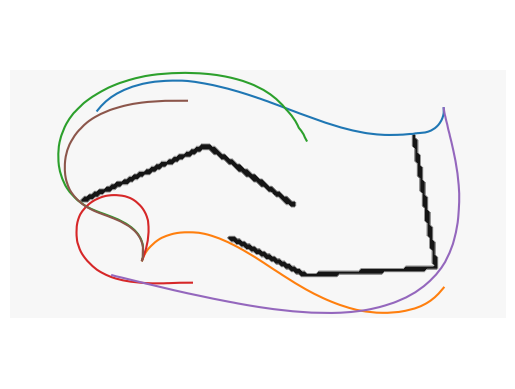

In [20]:
fig = plt.figure()
plt.contourf(*X,obstacles,cmap='Greys')
plt.axis('equal'); plt.axis('off')
for geo in hfmOut['geodesics']: plt.plot(*geo[:2])
#savefig(fig,"Output.png")